# Content Based Filtering

By: Nandakishore Vinayakrishnan - 23070854

In [25]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Dropout

df = pd.read_csv('../tmdb_5000_movies.csv')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [26]:
column_info = df.dtypes
print(column_info)

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object


## Steps:

1. Identify the columns to drop
    * Drop 'homepage', 'original_language', 'popularity', 'release_date', 'status', 'original_title', 'vote_average', 'vote_count'
2. Extract the genres, keywords, and production companies from their respective columns
3. Feature Engineering
4. Implementing Neural Network model
5. Model Evaluation

# Data Preprocessing

### Step 1: Identify the columns to drop

The columns to drop are:

1. 'budget'
2. 'homepage'
3. 'original_language'
4. 'original_title'
5. 'release_date'
6. 'spoken_languages'
7. 'status'
8. 'revenue'
9. 'vote_average'
10. 'vote_count'
11. 'popularity'

These columns were removed because we didn't see a reason to implement them in the model since they have very little important metadata.

In [27]:
drop_cols = ['budget', 'homepage', 'original_language', 
            'original_title', 'release_date', 'spoken_languages', 
            'status', 'revenue', 'vote_average', 
            'vote_count', 'popularity']
df = df.drop(drop_cols, axis=1)

### Step 2: Extract metadata from columns

In [28]:
def extract_features(x):
    return [i['name'] for i in ast.literal_eval(x)] if pd.notnull(x) else []

df['genres_list'] = df['genres'].apply(extract_features)
df['keywords_list'] = df['keywords'].apply(extract_features)
df['production_companies'] = df['production_companies'].apply(extract_features)
df['production_countries'] = df['production_countries'].apply(extract_features)

### Step 3: Feature Engineering

Encode the genres using MultiLabelBinarizer, and vectorize movie overview using TfidfVectorizer.

In [29]:
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(df['genres_list'])
keywords_features = mlb.fit_transform(df['keywords_list'])
production_companies_features = mlb.fit_transform(df['production_companies'])
production_countries_features = mlb.fit_transform(df['production_countries'])

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
overview_features = tfidf.fit_transform(df['overview'].fillna(''))
title_features = tfidf.fit_transform(df['title'])
tagline_features = tfidf.fit_transform(df['tagline'].fillna(''))

Stack the encoded genres and vectorized movie overview into a single array, X, which is the model input.

In [30]:
X = np.hstack([
    genre_features, 
    keywords_features,
    production_companies_features,
    production_countries_features,
    overview_features.toarray(),
    title_features.toarray(), 
    tagline_features.toarray()
    ])

### Step 4: Implementing the Neural Network Model

The model is implemented using a simple neural network with 3 hidden layers and a dropout layer to prevent overfitting.

The network architecture is as follows:
1. Input Layer
2. Dense layer with 256 units and ReLU activation
3. Dropout layer with 0.3 dropout rate
4. Dense layer with 128 units and ReLU activation
5. Dense layer with 64 units and ReLU activation
6. Embedding layer with 64 units to capture compressed representation of the input
7. Output layer with same number of units as input dimensions + linear activation function

In [31]:
input_dim = X.shape[1]
embedding_dim = 64

input_layer = Input(shape=(input_dim,))
dense_1 = Dense(256, activation='relu')(input_layer)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dense_3 = Dense(64, activation='relu')(dense_2)
embedding = Dense(embedding_dim, name='embedding')(dense_3)
output_layer = Dense(input_dim, activation='linear')(embedding)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.fit(X, X, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 9.7604e-04 - val_loss: 6.3843e-04
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 8.9789e-04 - val_loss: 6.3119e-04
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 9.0012e-04 - val_loss: 6.0439e-04
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.6262e-04 - val_loss: 5.9495e-04
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.6092e-04 - val_loss: 5.8255e-04
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.2756e-04 - val_loss: 5.7604e-04
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 8.2559e-04 - val_loss: 5.7229e-04
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.1111e-04 - val_loss: 5.6867e-04
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.0826e-04 - val_loss: 5.6296e-04
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 8.0413e-04 - val_loss: 5.5978e-04
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/

Pulls activations from embedding layer and uses them as the output of the model.

In [32]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)
embeddings = embedding_model.predict(X)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Step 5: Model Evaluation

Function takes a TMDB ID as input and returns the top 10 recommendations based on cosine simularity between the **embeddings** of the input movie & **embeddings** of all other movies in the dataset.

Simularity scores are sorted in descending order and the top 10 movies with highest sim scores are returned.

In [33]:
def nn_recommend(tmdb_id, n=10):
    try:
        idx = df[df['id'] == tmdb_id].index[0]
    except:
        return ["Movie not found"]
    
    sim_scores = cosine_similarity([embeddings[idx]], embeddings)[0]
    top_indices = sim_scores.argsort()[-n-1:-1][::-1]
    
    return [f"{row['id']} - {row['title']}" for _, row in df.iloc[top_indices].iterrows()]

nn_recommend(206647) # Spectre, just to test the function

['59859 - Kick-Ass 2',
 '10764 - Quantum of Solace',
 '20662 - Robin Hood',
 '23483 - Kick-Ass',
 '1637 - Speed',
 '258489 - The Legend of Tarzan',
 '8195 - Ronin',
 '8987 - The River Wild',
 '98 - Gladiator',
 '9654 - The Italian Job']

### Model Performance Evaluation

Evaluate the model performance using Mean Squared Error (MSE) on the training and validation sets.

In [34]:
train_preds = model.predict(X)
train_mse = mean_squared_error(X, train_preds)
print(f'Training MSE: {train_mse}')

val_preds = model.predict(X[int(0.8*len(X)):])
val_mse = mean_squared_error(X[int(0.8*len(X)):], val_preds)
print(f'Validation MSE: {val_mse}')

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Training MSE: 0.0007236026124512619
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation MSE: 0.0005466841470277148


### Embedding Visualization

Visualize the embeddings using t-SNE to understand the clustering of similar movies.

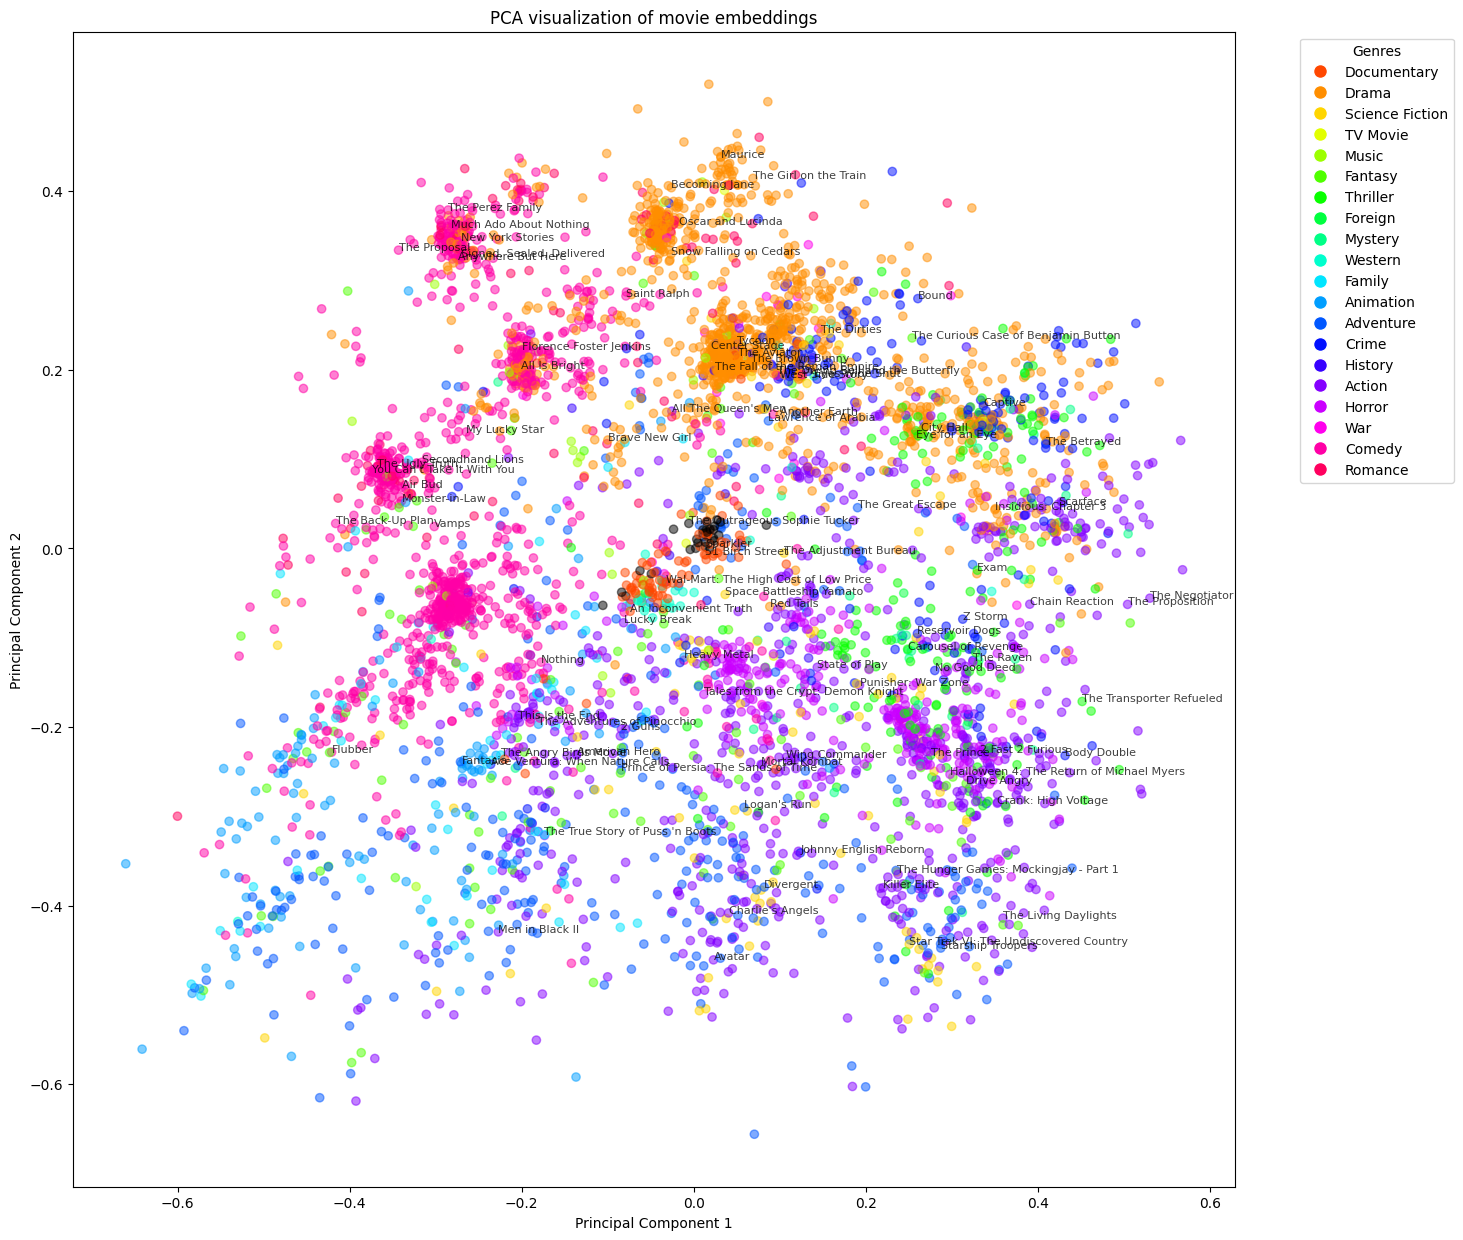

In [ ]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

unique_genres = set([genre for sublist in df['genres_list'] for genre in sublist])
palette = sns.color_palette("hsv", len(unique_genres))
genre_color_map = {genre: palette[i] for i, genre in enumerate(unique_genres)}

colors = [genre_color_map[df['genres_list'].iloc[i][0]] if df['genres_list'].iloc[i] else (0, 0, 0) for i in range(len(df))]

plt.figure(figsize=(15, 15))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.5)

for i in range(0, len(df), 50):  # Label every 20th point
    plt.annotate(df['title'].iloc[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.75)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=genre_color_map[genre], markersize=10) for genre in unique_genres]
plt.legend(handles, unique_genres, title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('PCA visualization of movie embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()